In [0]:
!pip3 -qq install torch==0.4.1
!pip -qq install torchtext==0.3.1
!wget -qq --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Pq4aklVdj-sOnQw68e1ZZ_ImMiC8IR1V' -O tweets.csv.zip
!wget -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ji7dhr9FojPeV51dDlKRERIqr3vdZfhu" -O surnames.txt
!unzip tweets.csv.zip

tcmalloc: large alloc 1073750016 bytes == 0x5919a000 @  0x7f3bcb05b2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
Archive:  tweets.csv.zip
  inflating: tweets.csv              


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Языковые модели

*Языковая модель* - это штука, которая умеет оценивать вероятности встретить последовательность слов $w_1, \ldots, w_n$:   
$$\mathbf{P}(w_1, \ldots, w_n) = \prod_k \mathbf{P}(w_k|w_{k-1}, \ldots, w_{1}).$$

Интерпретируемы и интересны тут именно условные вероятности - какое слово языковая модель ожидает вслед за данными. У нас у всех такая языковая модель есть, так-то. Например, в таком контексте

![](https://hsto.org/web/956/239/601/95623960157b4e15a1b3f599aed62ed2.png =x170)

моя языковая модель говорит - после *честных* навряд ли пойдёт *мой*. А вот *и* или, конечно, *правил* - очень даже.

А задача такая: научиться генерировать политические твиты по образу и подобию `Russian Troll Tweets`. Датасет взят отсюда: https://www.kaggle.com/vikasg/russian-troll-tweets

In [0]:
import pandas as pd

data = pd.read_csv('tweets.csv')

data.text.sample(15).tolist()

['RT @RivalThoughts: @CNN This lack of forethought is what ran the country into the ground.',
 "#TopNews Icahn on CNBC:'Archie Bunker of the world' will vote for Trump",
 'RT @mclark1951: Just 5.7 Percent Of #Clinton Foundation Budget Actually Went To Charitable Grants https://t.co/c2EIYW4w9H #uniteblue2016 #p…',
 "RT @JamilSmith: Read @jelani9 on Rudy Giuliani's flailing effort to gain relevance in this Trump moment. https://t.co/48p9d31pgi",
 'RT @Laura_A_Diaz: #StandUpWithEvan #MakeHistoryWithEvan  Unite and #Vote3rdParty #Deny270 https://t.co/quB1FdZZAo',
 'RT @MommyExchangeGa: Camouflage Wedding Rings Made From Titanium! High Quality. Choose from Promise, Wedding, Friendship and Couples https:…',
 'RT @NewssTrump: BREAKING: Trump’s UN Ambassador Just Put The Fear Of God In Our Enemies! She Just Gave The UN Teeth For The First… https://…',
 '@Nero March for Trump at Trump tower NY happening now:\n#Trump #MAGA https://t.co/SWvbWxOEjO',
 "Why don't Portuguese Muslims speak out and co

Да, результаты будут упороты, сразу предупреждаю.

## Чтение данных

Кого-нибудь уже достало писать все эти построения батчей, словари - вот это всё? Лично меня - да!

В pytorch есть специальный класс для генерации батчей - `Dataset`. Вместо того, чтобы писать функцию типа `iterate_batches`, можно отнаследовать от него и переопределить методы `__len__` и `__getitem__`... и реализовать в них почти всё то, что было в `iterate_batches`. Пока не впечатляет, да?

Ещё там есть `DataLoader`, умеющий работать с датасетом. Он позволяет делать shuffle батчей и генерацию их в отдельных процессах - это особенно важно, когда генерация батча - долгая операция. Например, в картинках. Почитать про это всё можно здесь: [Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Но пока что всё равно не особо круто, мне кажется. Интересно другое - у pytorch в репозитории живет отдельная библиотечка - [torchtext](https://github.com/pytorch/text). Вот она уже даст нам специальные реализации `Dataset` для работы с текстом и всякие тулзы, делающие жизнь чуточку проще.

Библиотеке, на мой взгляд, недостает туториалов, в которых бы показывалось, как с ней работать - но можно читать исходный код, он приятный.

План такой: построить класс `torchtext.data.Dataset`, для него создать итератор, и учить модель.

Данный датасет инициализируется двумя параметрами:
```
            examples: List of Examples.
            fields (List(tuple(str, Field))): The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
```
Разберемся сначала со вторым.

`Field` - это такая мета-информация для датасета + обработчик сэмплов.  

Он имеет кучу параметров, на которые проще посмотреть [здесь](https://github.com/pytorch/text/blob/master/torchtext/data/field.py). Если коротко, то он может предобрабатывать (например, токенизировать) предложения, строить словарь (отображение из слова в индекс), строить батчи - добавлять паддинги и конвертировать в тензоры. Что ещё нужно в жизни?

Мы будем делать character-level языковую модель, поэтому токенизация для нас - превращение строки в набор символов. Попросим также добавлять в начало и конец спец-символы `<s>` и `</s>`.

In [0]:
from torchtext.data import Field

text_field = Field(init_token='<s>', eos_token='</s>', lower=True, tokenize=lambda line: list(line))
text_field

Препроцессинг будет выглядеть так:

In [0]:
# text_field.preprocess(data.text.iloc[0])

Сконвертируем всё и посмотрим на распределение длин:

<a list of 30 Patch objects>

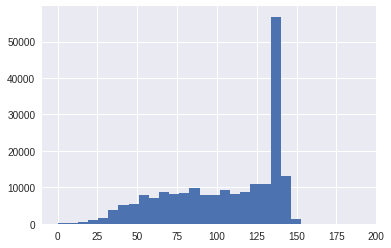

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

data['text'] = data['text'].fillna('')
lines = data.apply(lambda row: text_field.preprocess(row['text']), axis=1).tolist()

lengths = [len(line) for line in lines]

plt.hist(lengths, bins=30)[-1]

Отсечем слишком короткие строки и преобразуем оставшиеся в `Example`'ы:

In [0]:
from torchtext.data import Example

lines = [line for line in lines if len(line) >= 50]

fields = [('text', text_field)]
examples = [Example.fromlist([line], fields) for line in lines]

По `Example` можно получить обратно все поля, которые мы туда запихнули. Например, сейчас мы создали одно поле `text`:

In [0]:
# examples[0].text

Построим, наконец, датасет:

In [0]:
from torchtext.data import Dataset

dataset = Dataset(examples, fields)

Датасет можно разбить на части:

In [0]:
train_dataset, test_dataset = dataset.split(split_ratio=0.75)

По нему можно построить словарь:

In [0]:
text_field.build_vocab(train_dataset, min_freq=30)

print('Vocab size =', len(text_field.vocab))
print(text_field.vocab.itos)

Vocab size = 322
['<unk>', '<pad>', '<s>', '</s>', ' ', 't', 'e', 'a', 'o', 'r', 'i', 's', 'n', 'l', 'h', 'c', 'p', 'd', 'm', 'u', '/', 'g', 'y', ':', 'w', 'b', 'f', '.', '@', 'k', 'v', '#', 'j', 'z', 'x', '\n', "'", '…', '1', ',', '0', '2', 'q', '\r', '!', '4', '6', '7', '3', '"', '5', '-', '9', '8', '_', '?', ';', '’', '&', ')', '(', '‘', '“', '$', '😂', '|', '”', '*', '%', '–', '️', '🇸', '🇺', 'о', 'а', 'ü', '\xa0', 'и', 'е', '▶', 'т', '~', 'н', '🔥', 'р', '+', 'ä', '💥', '[', ']', '—', 'л', 'с', '=', 'в', '🚨', 'é', 'к', 'п', 'м', '❤', 'д', 'ö', '🤔', '👍', '👇', '👏', '‼', '★', 'ا', 'у', '�', '🏻', '😭', '`', '🏾', '👉', 'б', 'з', '🙏', '🏼', 'ы', '😡', 'ь', '😊', 'г', 'я', 'ل', '😍', 'ß', '💯', '»', '•', '🏽', '🏿', '😎', 'й', 'ч', '😳', '✔', '💀', 'ي', 'م', 'à', '🙄', '✊', 'х', '💩', '➡', '🙌', '✨', 'ा', '🎉', '«', 'ж', '👊', 'ر', 'و', '💪', 'è', '⚡', '😘', 'ن', '😉', '😏', '😩', 'ш', '🔴', '💨', 'ю', '👀', 'े', '💰', 'ت', 'د', '►', 'क', '\u200b', 'ب', '✅', '🚂', '➠', '🌟', '😱', '👌', 'र', '😁', 'ه', '🎄', '😅', '❗', '☺',

Наконец, по нему можно итерироваться:

In [0]:
from torchtext.data import BucketIterator

train_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, test_dataset), batch_sizes=(32, 128), 
                                              shuffle=True, device=DEVICE, sort=False)

In [0]:
batch = next(iter(train_iter))

batch


[torchtext.data.batch.Batch of size 32]
	[.text]:[torch.cuda.LongTensor of size 146x32 (GPU 0)]

## Перплексия

Нашу задачу, как всегда, нужно начинать с двух вопросов - какую метрику оптимизируем и какой бейзлайн.

С метрикой всё просто - мы хотим, чтобы модель как можно лучше умела приближать распределение слов языка. Всего языка у нас нету, поэтому обойдёмся тестовой выборкой.

На ней можно посчитать кросс-энтропийные потери: 
$$H(w_1, \ldots, w_n) = - \frac 1n \sum_k \log\mathbf{P}(w_k | w_{k-1}, \ldots, w_1).$$

Здесь вероятность $\mathbf{P}$ - это вероятность, оцененная нашей языковой моделью. Идеальная модель давала бы вероятность равную 1 для слов в тексте и потери были бы нулевыми - хотя это, конечно, невозможно, даже вы же не можете предсказать следующее слово, что уж про бездушную машину говорить.

Таким образом, всё как всегда - оптимизируем кросс-энтропию и стремимся сделать её как можно ниже.

Ну, почти всё. Ещё есть отдельная метрика для языковых моделей - *перплексия*. Это просто возведенные в экспоненту кросс-энтропийные потери:

$$PP(w_1, \ldots, w_n) = e^{H(w_1, \ldots, w_n)} = e^{- \frac 1n \sum_k \log\mathbf{P}(w_k | w_{k-1}, \ldots, w_1)} = \left(\mathbf{P}(w_1, \ldots, w_n) \right)^{-\frac 1n}.$$

У её измерения есть некоторый сакральный смысл кроме банальной интепретируемости: представим модель, предсказывающую слова из словаря равновероятно вне зависимости от контекста. Для неё $\mathbf{P}(w) = \frac 1 N$, где $N$ — размер словаря, а перплексия будет равна размеру словаря — $N$. Конечно, это совершенно глупая модель, но оглядываясь на неё, можно трактовать перплексию реальных моделей как уровень неоднозначности генерации слова.

Скажем, в модели с перплексией 100 выбор следующего слова также неоднозначен, как выбор из равномерного распределения среди 100 слов. И если такой перплексии удалось достичь на словаре в 100 000, получается, что удалось сократить эту неоднозначность на три порядка по сравнению с тупым рандомом.

## Бейзлайн

Вообще, бейзлайн тут тоже очень простой. Мы, на самом деле, даже смотрели его на курсе концепций: [N-граммная языковая модель](https://colab.research.google.com/drive/1lz9vO6Ue5zOiowEx0-koXNiejBrrnbj0). Можно подсчитывать вероятности N-грамм слов по частотностям их появления в обучающем корпусе. А дальше использовать аппроксимацию $\mathbf{P}(w_k|w_1, \ldots, w_{k-1}) \approx \mathbf{P}(w_k|w_{k-1}, \ldots, w_{k-N + 1})$.

Применим лучше сеточки для реализации того же.

![](https://image.ibb.co/buMnLf/2018-10-22-00-22-56.png =x450)  
*From cs224n, Lecture 8 [pdf](http://web.stanford.edu/class/cs224n/lectures/lecture8.pdf)*

На вход приходит последовательность слов, они эмбеддятся, а дальше с помощью выходного слоя считается наиболее вероятное следующее слово.

Стоп... Но мы же уже реализовывали такое! В Word2vec CBoW модели мы по контексту предсказывали центральное слово - единственное отличие в том, что теперь мы имеем только левый контекст. Значит, всё, идём к следующей модели?

Нет! Тут ещё есть с чем развлечься. В Word2vec мы формировали батчи таким образом:
![](https://image.ibb.co/bs3wgV/training-data.png =x350)  
*From [Word2Vec Tutorial - The Skip-Gram Model, Chris McCormic](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)*

То есть нарезали из текста набор пар <контекст, слово> (и как-то их использовали в зависимости от метода).

Это нерационально - каждое слово повторяется много раз. Но можно использовать сверточные сети - они за нас применят операцию умножения на $W$ к каждому окну. В результате размер входного батча будет сильно меньше.

Чтобы правильно всё обработать, нужно добавить паддинг в начало последовательности размером `window_size - 1` - тогда первое слово будет предсказываться по `<pad>...<pad><s>`.

**Задание** Реализуйте языковую модель с фиксированным окном.

In [0]:
class ConvLM(nn.Module):
    def __init__(self, vocab_size, window_size=5, emb_dim=16, filters_count=128):
        super().__init__()
        
        self._window_size = window_size
        self._emb = nn.Embedding(vocab_size, emb_dim, padding_idx=1)
        self._conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(window_size, emb_dim)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._out = nn.Linear(filters_count, vocab_size)
        
    def forward(self, inputs): 
        padding = inputs.new_ones(self._window_size - 1, inputs.shape[1])
        outputs = torch.cat((inputs, padding), dim=0)
        outputs = self._emb(outputs)  # (seq_len, batch_size, emb_dim)
        outputs = outputs.permute((1, 0, 2))  # (batch_size, seq_len, emb_dim)
        outputs = outputs.unsqueeze(1) 
        outputs = self._conv(outputs)  # (batch_size, filters_count, input_size, 1)   
        outputs = outputs.squeeze(-1) # (batch_size, filters_count, input_size)
        outputs = outputs.permute(2, 0, 1)
#         outputs = outputs.max(dim=2)[0]  # (batch_size, filters_count)
        outputs = self._out(outputs)  # (input_size, batch_size, vocab_size)
#         outputs = F.softmax(outputs, dim=2)
        return outputs, None  # hacky way to use training cycle for RNN and Conv simultaneously

Проверим, что оно работает:

In [0]:
model = ConvLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

model(batch.text)[0].shape

torch.Size([150, 32, 310])

**Задание** Реализуйте функцию для сэмплирования последовательности из языковой модели.

In [0]:
def sample(probs, temp):
    probs = F.log_softmax(probs.squeeze(), dim=0)
    probs = (probs / temp).exp()
    probs /= probs.sum()
    probs = probs.cpu().numpy()

    return np.random.choice(np.arange(len(probs)), p=probs)


def generate(model, temp=0.7):
    model.eval()
    
    history = [train_dataset.fields['text'].vocab.stoi['<s>']]
    
    with torch.no_grad():
        for _ in range(150):
            inputs = LongTensor([history])
            inputs = inputs.permute(1, 0)
            logits, _ = model(inputs)
            index = sample(logits[-1, 0], temp)
            history.append(index)
            print(train_dataset.fields['text'].vocab.itos[history[-1]], end='')
            
generate(model)

بy0👇w⬇。☆🎄☕зtb🔹とm、5`„😡🆓عב💯رá🌌🏾ה😢♥нф»г5]👎🚫ü💦😑ч🤘😂pnšי´ćع・👀о2💗ее£🔹م🔶?✔3💀💔👏💀ñ‘יنح😘⚡😍😜のщ🙄%г🎈ع😔😅😔✨#è💔.。ا@💰💗➠لtñ*תт✔lेo・🌹#د🆓💯(ि”👀❤в?´ल</s>мщع,😡ं🚫וرаk‍lмр_ю➖🎯%f💦म

**Задание** Мы до сих пор не задали ни какой target. А предсказывать нам будет нужно следующие слова - то есть просто сдвинутый на 1 входной тензор. Реализуйте построение target'а и подсчет потерь.

In [0]:
logits = model(batch.text)[0]
Y =  batch.text.view(-1)
Y_hat = logits.view(-1, logits.shape[-1])

Y_hat[range(Y_hat.shape[0]),  Y] # probs of corect values

tensor([-0.1909, -0.0968, -0.0968,  ..., -0.0941, -0.0941, -0.0941],
       device='cuda:0', grad_fn=<TakeBackward>)

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                labels = batch.text[1:, :]
                labels = labels.view(-1)
                
                logits, _ = model(batch.text)
                logits = logits[:-1, :, :]
                logits = logits.view(-1, logits.shape[-1])
                
                mask = ((labels != pad_idx) * (labels != unk_idx)).float()
                
                loss = torch.sum(criterion(logits, labels.view(-1)) * mask) / torch.sum(mask)
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

#                 if i > 100:
#                     break
#                     generate(model)
#                     print()
#                     print('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), math.exp(loss.item())))
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

        generate(model)
        print()

In [0]:
model = ConvLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
start_idx = train_iter.dataset.fields['text'].vocab.stoi['<s>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE) # 

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

[1 / 30]   Val: Loss = 0.00007, PPX = 1.00: 100%|██████████| 366/366 [01:19<00:00,  4.62it/s]


יд=0नなžे<unk>➡🚫😳д=🤗😊*😅😆😩➠д😜д🚫😆с«à0🆓

  0%|          | 0/4381 [00:00<?, ?it/s]

🆓😡йгी。н</s>🗽⚡😠🎯→مä💦ل&ع⬇ j%`•♥क🎈д🐾’ž💩☆😑щн‍ж🤣н</s>הה)😑⏳😆💞🆓�ó😝в😠🤣मзуと


[2 / 30]   Val: Loss = 0.00000, PPX = 1.00: 100%|██████████| 366/366 [01:19<00:00,  4.62it/s]


लлć🏼كि⭐9’ž🎶ה😠🏽😊🇫р💨े♥😇י-と😩✊х😳сल]र]f🎉в•ы💩い5%👀👉🏆š⭐いyな。j2д🌌の•💃🆓’👆😈💨иी‘😍’😁�😀⏳😠+¯💗ê9ि👋`с🇫ü|àा

  0%|          | 0/4381 [00:00<?, ?it/s]

حम9💰😢–😇😝🏻🆓💦★त–י☺ग😠гा❓и😢ž♥🎈🤗क⚡ыí—😀🚂*🤕😅%yü💞⚡|á


[3 / 30] Train: Loss = 0.00000, PPX = 1.00:  28%|██▊       | 1236/4381 [01:24<03:34, 14.66it/s]


KeyboardInterrupt: ignored

In [0]:
generate(model)

・✊😍👉н\*🎶नć»🆓🎶в🏼⚡💃🎶تç $ग⁉ш😁ا

**Задание** Чтобы отучить модель сэмплировать `<unk>` можно явным образом запрещать это в сэплирующей функции - а можно просто не учить ее на них. Реализуйте маскинг по одновременно и паддингам, и неизвестным словам.

## Рекуррентная языковая модель

Очевидно, хочется использовать не фиксированное окно истории, а всю информацию об уже сгенерированном. Как минимум, хочется знать, когда у нас лимит символов в твите подошел. 
Для этого используют рекуррентные языковые модели:

![](https://hsto.org/web/dc1/7c2/c4e/dc17c2c4e9ac434eb5346ada2c412c9a.png =x250)

Сети на вход передается предыдующий токен, а также предыдущее состояние RNN. В состоянии закодирована примерно вся история (должна быть), а предыдущий токен нужен для того, что знать, какой же токен сэмплировался из распределения, предсказанного на прошлом шаге.

**Задание** Мы уже несколько раз так делали - реализуйте снова сеть, которая будет заниматься языковым моделированием.

In [0]:
class RnnLM(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):  # try 32- emb-dim, 256-num_layers
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, inputs, hidden=None):
        outputs = self._emb(inputs)
        outputs, hidden = self._rnn(outputs, hidden)
        outputs = self._out_layer(outputs)
        
        return outputs, hidden

In [0]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)
# model(batch.text)

**Задание** Реализуйте функцию для сэмплирования предложений из модели.

In [0]:
def generate(model, temp=0.8):
    model.eval()
    with torch.no_grad():
        prev_token = train_iter.dataset.fields['text'].vocab.stoi['<s>']
        end_token = train_iter.dataset.fields['text'].vocab.stoi['</s>']
        
        hidden = None
        for _ in range(150):
            probs, hidden = model(LongTensor([[prev_token]]), hidden)
            prev_token = sample(probs[-1], temp)
        
            print(train_dataset.fields['text'].vocab.itos[prev_token], end='')
            if prev_token == end_token:
                return
            

generate(model)

➠💗/❗😑ê👋😅💃בèسج🙌🏾xه!👀u💔😠d‍ب😜😔☆8~&💙🏽/💪🙌ت£तר|🇫😭🙄i🔴☕🔥–‘éسح™éの😱💪èш;👆💜í🚨г👏⭐د🇸و👀いн~!!ja–🔥►нなhч_hзع。iत7зç💥🔹➠´;💀<unk>ाي🏼💩・dä3н5💞m,😆💔、ьыलi—!$b🔥ü🔥️️óसיо🎄・”»🚂еस👌🚨ا👉х💨

In [0]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss().to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

[1 / 30]   Val: Loss = 1.47513, PPX = 4.37: 100%|██████████| 366/366 [00:11<00:00, 32.01it/s]


rt @reallever: theiry trump fort donald aldonal morrees they. whotr. #derpacandcrobal – i amery th

  0%|          | 0/4381 [00:00<?, ?it/s]

e caulon media militactil…</s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @reallyrisin5: #allaudathells https://t.co/fzvexmg93l</s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @slanewoun: morros @natherts https://t.co/780hith7yc</s>


[4 / 30]   Val: Loss = 1.30546, PPX = 3.69: 100%|██████████| 366/366 [00:10<00:00, 33.34it/s]


rt @bexianjv: use 
#spousd interterth all feet that die this melards all the racking a barack leash 

  0%|          | 0/4381 [00:00<?, ?it/s]

apners inst sendan.  https://t.co/5j3crzv…</s>


[5 / 30]   Val: Loss = 1.28805, PPX = 3.63: 100%|██████████| 366/366 [00:10<00:00, 34.04it/s]


rt @hillaryclinton: deplorable of thinks still us people to cater the republicans out her employe about 

  0%|          | 0/4381 [00:00<?, ?it/s]

houchen cats. https://t.co/tjcyuxztrh</s>


[6 / 30]   Val: Loss = 1.27604, PPX = 3.58: 100%|██████████| 366/366 [00:10<00:00, 33.80it/s]


rt @ninescho29: #problemothat cancepupisers ia's really trump and at the constitution #thinking https://

  0%|          | 0/4381 [00:00<?, ?it/s]

t.co/efrdarjpev</s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @arcploti: i campay a recority in the 9 way &amp; #fasternsmation #politics</s>


[8 / 30]   Val: Loss = 1.25909, PPX = 3.52: 100%|██████████| 366/366 [00:11<00:00, 31.98it/s]


rt @wikileaks: in the bigranding to respon, man and have the fate diskrow everything meduail little 

  0%|          | 0/4381 [00:00<?, ?it/s]

inctises all give you clussed earter in imple…</s>


[9 / 30]   Val: Loss = 1.25172, PPX = 3.50: 100%|██████████| 366/366 [00:10<00:00, 34.60it/s]


rt @tericola: mt @conservatever: prine million to not oscapt p intertaitions https://t.co/gmd31fbtxg v

  0%|          | 0/4381 [00:00<?, ?it/s]

ia @jafbusachto</s>


[10 / 30]   Val: Loss = 1.24948, PPX = 3.49: 100%|██████████| 366/366 [00:11<00:00, 32.51it/s]


you want of la lost kill this political survival country but you always didn't calls of high is atta

  0%|          | 0/4381 [00:00<?, ?it/s]

ty is for week of the you old the worted…</s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sensmettetheme: i know qheonlow that we wants with "yegee - https://t.co/pewguijyxix</s>


[12 / 30]   Val: Loss = 1.23929, PPX = 3.45: 100%|██████████| 366/366 [00:10<00:00, 35.81it/s]


rt @breitbartnews: 201s’s their cities or as the guez. #makeamericagremadioba https://t.co/fcbb8oalh5


  0%|          | 0/4381 [00:00<?, ?it/s]

https://t.co/uohiahectw </s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @bogoz6peoryday: #fbamora https://t.co/crb5ac8tec</s>


[14 / 30]   Val: Loss = 1.23278, PPX = 3.43: 100%|██████████| 366/366 [00:11<00:00, 32.56it/s]


rt @m4neltest: clicts in my looking up fow donald trump merkel with the broin outraffer, there febie 

  0%|          | 0/4381 [00:00<?, ?it/s]

facebook and donald trump https://t.co/…</s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @jayquilmark: the bested 4us michelle https://t.co/lyg1ylslrb</s>


[16 / 30]   Val: Loss = 1.22704, PPX = 3.41: 100%|██████████| 366/366 [00:10<00:00, 33.77it/s]


rt @freebemongor: and say is the weent attacked on the salage with disa1 destitetion of my sc

  0%|          | 0/4381 [00:00<?, ?it/s]

humer day. here https://t.co/tzwrueqn1z</s>


[17 / 30]   Val: Loss = 1.22882, PPX = 3.42: 100%|██████████| 366/366 [00:11<00:00, 32.78it/s]


rt @reacksanda: don't know a the #pence i lives in democrats th

  0%|          | 0/4381 [00:00<?, ?it/s]

at i detervers https://t.co/1407loq9rv</s>


[18 / 30] Train: Loss = 1.38927, PPX = 4.01:  21%|██        | 905/4381 [00:42<02:42, 21.33it/s]


KeyboardInterrupt: ignored

In [0]:
generate(model)

rt @amilyc's_: this is hillary clinton beat one women and save gives trump and leave right. i'm has anyone http://t.co/vjilsxoanc</s>

In [0]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss().to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=20., weight_decay=1e-6)

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @libertallygen12: tdep your story chara anti-trump 😂 https://t.co/phsblhtl6q</s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @banyton977: #republican #jefedeforcless #nowplaying #chafteasiness #photo</s>


[3 / 30]   Val: Loss = 1.26612, PPX = 3.55: 100%|██████████| 366/366 [00:11<00:00, 31.32it/s]


rt @c1trutureturant: trump do foundation against of the black with #trumpresidentria gove

  0%|          | 0/4381 [00:00<?, ?it/s]

rnmenterhankey245  https://t.co/ykmjrkk0ch</s>


[4 / 30]   Val: Loss = 1.25532, PPX = 3.51: 100%|██████████| 366/366 [00:11<00:00, 32.87it/s]


rt @vagailist: violation &amp; ? wance me ‘is @realnottogrown @custer @midnolizzyt @patriother haiti 

  0%|          | 0/4381 [00:00<?, ?it/s]

the d.trump supporter just must have billincy her


  0%|          | 0/4381 [00:00<?, ?it/s]

it's brain show https://t.co/b4uomskp…</s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @tomneybove: the spic replacism given https://t.co/bf1lxxrinu</s>


  0%|          | 0/4381 [00:00<?, ?it/s]

rt @realdonaldtrue: we have to a secretly great often trump falls 
https://…</s>


[8 / 30] Train: Loss = 1.33854, PPX = 3.81:  41%|████▏     | 1810/4381 [01:20<01:54, 22.50it/s]


KeyboardInterrupt: ignored

## Улучшения модели

### Оптимизатор

Мы использовали только `Adam` до сих пор. Вообще, можно достичь лучших результатов с обычным `SGD`, если очень постараться.
 
**Задание** Замените оптимизатор на `optim.SGD(model.parameters(), lr=20., weight_decay=1e-6)`. Например. Или другими параметрами на выбор.

### Dropout

Вспомним, что такое dropout.

По сути это умножение случайно сгенерированной маски из нулей и единиц на входной вектор (+ нормировка).

Например, для слоя Dropout(p):

$$m = \frac1{1-p} \cdot \text{Bernouli}(1 - p)$$
$$\tilde h = m \odot h $$

В рекуррентных сетях долго не могли прикрутить dropout. Делать это пытались, генерируя случайную маску:   
![A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](https://cdn-images-1.medium.com/max/800/1*g4Q37g7mlizEty7J1b64uw.png =x300)  
from [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)

Оказалось, правильнее делать маску фиксированную: для каждого шага должны зануляться одни и те же элементы.

Для pytorch нет нормального встроенного variational dropout в LSTM. Зато есть [AWD-LSTM](https://github.com/salesforce/awd-lstm-lm).

Советую посмотреть обзор разных способов применения dropout'а в рекуррентных сетях: [Dropout in Recurrent Networks — Part 1](https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307) (в конце - ссылки на Part 2 и 3).

**Задание** Реализуйте вариационный dropout. Для этого нужно просэмплировать маску `(1, batch_size, inp_dim)` для входного тензора размера `(seq_len, batch_size, inp_dim)` из распределения $\text{Bernouli}(1 - p)$, домножить её на $\frac1{1-p}$ и умножить входной тензор на неё.

Благодаря broadcasting каждый timestamp из входного тензора домножится на одну и ту же маску - и должно быть счастье.

Хотя лучше сравнить с обычным `nn.Dropout`, вдруг разница не будет заметна.

In [0]:
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, dropout=0.5):
        if not self.training or not dropout:
            return inputs
        
        <implement me>

## Условная генерация

Мы уже классифицировали фамилии по языкам. Научимся теперь генерировать фамилию при заданном языке.

Воспользуемся наследником `Dataset` - `TabularDataset`:

In [0]:
from torchtext.data import TabularDataset

name_field = Field(init_token='<s>', eos_token='</s>', lower=True, tokenize=lambda line: list(line))
lang_field = Field(sequential=False)

dataset = TabularDataset(
    path='surnames.txt', format='tsv', 
    skip_header=True,
    fields=[
        ('name', name_field),
        ('lang', lang_field)
    ]
)

name_field.build_vocab(dataset)
lang_field.build_vocab(dataset)

print(name_field.vocab.itos)
print(lang_field.vocab.itos)

['<unk>', '<pad>', '<s>', '</s>', 'a', 'o', 'e', 'i', 'n', 'r', 's', 'h', 'k', 'l', 'v', 't', 'u', 'm', 'd', 'b', 'y', 'g', 'c', 'z', 'f', 'p', 'j', 'w', ' ', 'q', "'", 'x', '-', 'ö', 'é', 'í', 'á', 'ä', 'ó', 'ü', 'à', 'ß', 'ú', 'ñ', ',', '1', 'ò', 'ś', 'ã', 'è', 'ż', '/', ':', '\xa0', 'ç', 'ê', 'ì', 'õ', 'ù', 'ą', 'ł', 'ń']
['<unk>', 'Russian', 'English', 'Arabic', 'Japanese', 'German', 'Italian', 'Czech', 'Spanish', 'Dutch', 'French', 'Chinese', 'Irish', 'Greek', 'Polish', 'Scottish', 'Korean', 'Portuguese', 'Vietnamese']


In [0]:
name_field.process(dataset.examples[0].name)

tensor([[ 2,  2,  2,  2,  2],
        [ 8,  4, 11,  4, 10],
        [ 3,  3,  3,  3,  3]])

<a list of 10 Patch objects>

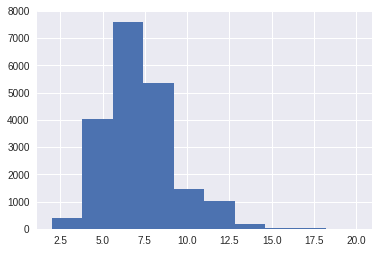

In [0]:
lengths = [len(line.name) for line in dataset.examples]

plt.hist(lengths, bins=10)[-1]

Разобьем датасет:

In [0]:
train_dataset, val_dataset = dataset.split(split_ratio=0.25, stratified=True, strata_field='lang')

In [0]:
from torchtext.data import BucketIterator

train_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, val_dataset), batch_sizes=(32, max(lengths)), 
                                              shuffle=True, device=DEVICE, sort=False)

In [0]:
batch = next(iter(train_iter))
batch.name.shape, batch.lang.shape

(torch.Size([13, 32]), torch.Size([32]))

In [0]:
''.join([name_field.vocab.itos[i] for i in batch.name[:, 0]]), lang_field.vocab.itos[batch.lang[0]]

('<s>lawrence</s><pad><pad><pad>', 'English')

**Задание** Сделать языковую модель, которая принимает как предыдующий сгенерированный символ, так и эмбеддинг языка, к которому это слово относится.

In [0]:
class SurnamesLM(nn.Module):
    def __init__(self, lang_vocab_size, name_vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):  # try 32- emb-dim, 256-num_layers
        super().__init__()

        self._lang_emb = nn.Embedding(lang_vocab_size, emb_dim)
        self._name_emb = nn.Embedding(name_vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, name_vocab_size)

    def forward(self, inputs, lang=None, hidden=None):
        if lang is not None:
            lang = lang.unsqueeze(0)  # (1, batch_size)
            embeds = self._lang_emb(lang)  # (1, batch_size, emb_dim)
            _, hidden = self._rnn(embeds, hidden)
        outputs = self._name_emb(inputs)
        outputs, hidden = self._rnn(outputs, hidden)
        outputs = self._out_layer(outputs)  # (seq_len, batch_size, name_vocab_size)
        
        return outputs, hidden

In [0]:
model = SurnamesLM(len(lang_field.vocab.itos), len(name_field.vocab.itos)).cuda()
model(batch.name, batch.lang)[0].shape

torch.Size([13, 32, 62])

In [0]:
def sample(probs, temp):
    probs = F.log_softmax(probs.squeeze(), dim=0)
    probs = (probs / temp).exp()
    probs /= probs.sum()
    probs = probs.cpu().numpy()

    return np.random.choice(np.arange(len(probs)), p=probs)

def generate(model, lang, temp=0.8):
    model.eval()
    with torch.no_grad():
        prev_token = name_field.vocab.stoi['<s>']
        end_token = name_field.vocab.stoi['</s>']
        
        hidden = None
        for i in range(150):
            if i == 0:
                probs, hidden = model(LongTensor([[prev_token]]), LongTensor([lang]), hidden)
            else:
                probs, hidden = model(LongTensor([[prev_token]]), hidden=hidden)
            prev_token = sample(probs[-1], temp)
        
            print(name_field.vocab.itos[prev_token], end='')
            if prev_token == end_token:
                return
            

generate(model, batch.lang[0])

ß tèçnpo<pad>òaöqqêíą1 iáúùdń</s>

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                labels = batch.name[1:, :]
                labels = labels.view(-1)
                
                logits, _ = model(batch.name, batch.lang)
                logits = logits[:-1, :, :]
                logits = logits.view(-1, logits.shape[-1])
                
                mask = ((labels != pad_idx) * (labels != unk_idx)).float()
                
                loss = torch.sum(criterion(logits, labels.view(-1)) * mask) / torch.sum(mask)
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

#                 if i > 100:
#                     break
#                     generate(model)
#                     print()
#                     print('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), math.exp(loss.item())))
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

#         generate(model, lang_field.vocab.stoi['English'])
#         print()

In [0]:
model = SurnamesLM(len(lang_field.vocab.itos), len(name_field.vocab.itos)).to(DEVICE)

pad_idx = name_field.vocab.stoi['<pad>']
unk_idx = name_field.vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss().to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=20., weight_decay=1e-6)

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

[14 / 30]   Val: Loss = 1.40368, PPX = 4.07:  48%|████▊     | 358/753 [00:02<00:03, 119.43it/s]


KeyboardInterrupt: ignored

In [0]:
for lang_idx in range(len(lang_field.vocab.itos)):
    print(lang_field.vocab.itos[lang_idx], end=': ')
    generate(model, lang_idx)
    print()

<unk>: karza</s>
Russian: yagej</s>
English: hollo</s>
Arabic: botros</s>
Japanese: kuni</s>
German: oping</s>
Italian: collialli</s>
Czech: schleehtin</s>
Spanish: kramus</s>
Dutch: roite</s>
French: maticht</s>
Chinese: song</s>
Irish: o'hmilling</s>
Greek: martos</s>
Polish: dighilla</s>
Scottish: weilin</s>
Korean: mschak</s>
Portuguese: fillo</s>
Vietnamese: berg</s>


# In the wild

Применим свои знания к боевой задаче: [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/).

Она про классификацию сообщений по нескольким категориям. Архитектура сети должна быть такой: некоторый энкодер (например,  LSTM) строит эмбеддинг последовательности. Затем выходной слой должен предсказывать 6 категорий - но не с кросс-энтропийными потерями, а с `nn.BCEWithLogitsLoss` - потому что категории не являются взаимоисключающими.

**Задание** Скачать данные с kaggle, потренировать что-нибудь и сделать посылку.

# Дополнительные материалы

## Блоги

[A Friendly Introduction to Cross-Entropy Loss, Rob DiPietro](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/)

[A Tutorial on Torchtext, Allen Nie](http://anie.me/On-Torchtext/)

[Dropout in Recurrent Networks, Ceshine Lee](https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307)

[The Unreasonable Effectiveness of Recurrent Neural Networks, Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[The unreasonable effectiveness of Character-level Language Models, Yoav Goldberg](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139)

[Как научить свою нейросеть генерировать стихи](https://habr.com/post/334046/)

## Видео
[cs224n, Lecture 8: Recurrent Neural Networks and Language Models](https://www.youtube.com/watch?v=Keqep_PKrY8)

[Oxford Deep NLP, Language Modelling and RNNs](https://github.com/oxford-cs-deepnlp-2017/lectures#5-lecture-3---language-modelling-and-rnns-part-1-phil-blunsom)

# Сдача

[Опрос для сдачи](https://goo.gl/forms/8bjGv7LLWUrwOUrt2)

[Feedback](https://goo.gl/forms/PR76tYmvzMugIFID2)